In [1]:
from collections import defaultdict
from itertools import product

import gym
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import ParameterSampler
from tqdm import tqdm

sns.set_theme(color_codes=True)

### Часть первая, с блекджеком и стратегиями

1. Рассмотрим очень простую стратегию: говорить `stand`, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить `hit`. Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии.

In [2]:
env = gym.make('Blackjack-v0')

In [3]:
def run_episode(env, pi, St2id):
    state = env.reset()
    states, rewards = [state], [0]
    for _ in range(1000):
        action = int(state[0]<19)
        state, reward, done, _ = env.step(pi[St2id[state]])
        states.append(state)
        rewards.append(reward)
        if done:
            break
    return states, rewards

In [4]:
# состояния
St = list(product(range(4,32),range(1,11),(False,True)))
St2id = {}
for i, st in enumerate(St):
    St2id[st]=i

In [5]:
simple_pi = [0]*len(St)
for st in St:
    s1, _, _ = st
    if s1 < 19:
        simple_pi[St2id[st]] = 1

In [6]:
def mc_prediction(pi, env, St2id, n_episodes):
    value_table = defaultdict(float)
    N = defaultdict(int)
    for _ in range(n_episodes):
        states, rewards = run_episode(env, pi, St2id)
        returns = 0
        for t in range(len(states) - 1, -1, -1):
            R = rewards[t]
            S = states[t]
            returns += R
            if S not in states[:t]:
                N[S] += 1
                value_table[S] += (returns - value_table[S]) / N[S]
    return value_table

In [7]:
def get_mc_reward(pi, env, St2id, n_iter=500000):
    value_table = mc_prediction(pi, env, St2id, n_iter)
    init_states = [r for (s, r) in value_table.items() if 12 <= s[0] <= 20]
    return np.mean(init_states)

In [8]:
# состояния с суммой от 12 до 20, так как состояния с суммой < 12 сводятся к этим
rew = get_mc_reward(simple_pi, env, St2id)
print(rew)

-0.1688627099803447


2. Реализуйте метод обучения с подкреплением без модели (можно Q-обучение, но рекомендую попробовать и другие, например Monte Carlo control) для обучения стратегии в блекджеке, используя окружение Blackjack-v0 из OpenAI Gym.

In [9]:
def get_a(pi, state, epsilon, nA):
    if np.random.rand() > epsilon:
        return pi[state] 
    else:
        return np.random.randint(nA)

def compute_policy_by_Q(Q):
    return np.argmax( Q, axis=1 )

In [10]:
def Q_learning_episode(env, pi, Q, nA, St2id, alpha=0.05, epsilon=0.03, gamma=0.9):
    s = env.reset()
    a = get_a(pi, St2id[s], epsilon, nA)
    for _ in range(1000):
        state_prime, reward, done, _ = env.step(a)
        a_prime = get_a(pi, St2id[state_prime], epsilon, nA)
        Q[St2id[s]][a] = Q[St2id[s]][a] + alpha * \
            (reward + gamma * np.max(Q[St2id[state_prime]]) - Q[St2id[s]][a])
        s, a = state_prime, a_prime
        if done:
            break

In [11]:
Q = np.zeros((len(St),2))
pi = compute_policy_by_Q(Q)
nA = 2 # 2 состояния
total_episodes=500000

for n in tqdm(range(total_episodes)):
    Q_learning_episode(env, pi, Q, nA, St2id, epsilon=0.03)
    pi = compute_policy_by_Q(Q)

100%|██████████| 500000/500000 [00:43<00:00, 11475.76it/s]


In [12]:
rew = get_mc_reward(pi, env, St2id)
print(rew)

-0.13822045537872932


In [13]:
param_grid = {'alpha': np.linspace(1e-3,3e-1,10), 'gamma': np.linspace(1e-3,3e-1,10)}

In [14]:
nA = 2 # 2 состояния
total_episodes=100000
param_list=[]
rew_list=[]
for param in tqdm(ParameterSampler(param_grid, n_iter=10, random_state=123)):
    Q = np.zeros((len(St),2))
    pi = compute_policy_by_Q(Q)
    for n in range(total_episodes):
        Q_learning_episode(env, pi, Q, nA, St2id, param['alpha'], 0.03, param['gamma'])
        pi = compute_policy_by_Q(Q)
        
    rew = get_mc_reward(pi, env, St2id)
    rew_list.append(rew)
    param_list.append(param)

100%|██████████| 10/10 [06:14<00:00, 37.42s/it]


In [15]:
param_list[np.argmax(rew_list)]

{'gamma': 0.1338888888888889, 'alpha': 0.001}

In [16]:
Q = np.zeros((len(St),2))
pi = compute_policy_by_Q(Q)
nA = 2 # 2 состояния
total_episodes=1000000
cur_pos = 1
border = np.linspace(100,total_episodes+1,11)
history = []
for n in tqdm(range(total_episodes)):
    if border[cur_pos] < n:
        rew = get_mc_reward(pi, env, St2id)
        cur_pos += 1
        history.append((n, rew))
    Q_learning_episode(env, pi, Q, nA, St2id, epsilon=0.03, **param_list[np.argmax(rew_list)])
    pi = compute_policy_by_Q(Q)
rew = get_mc_reward(pi, env, St2id)
history.append((total_episodes, rew))

100%|██████████| 1000000/1000000 [05:58<00:00, 2787.34it/s]


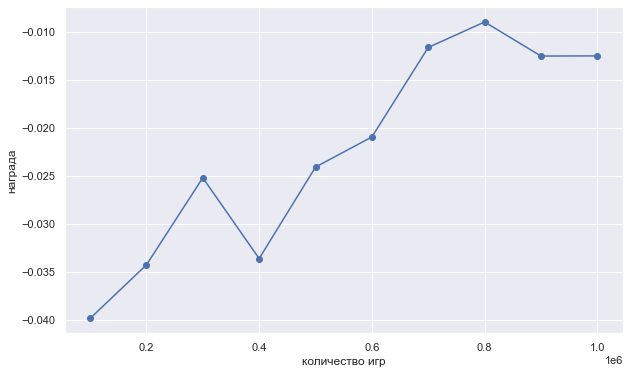

In [17]:
plt.figure(figsize=(10,6))
x, y = list(zip(*history))
ax, = plt.plot(x,y, linestyle='-', marker='o', color='b')
plt.xlabel('количество игр')
plt.ylabel('награда')
plt.show()

In [18]:
history

[(100091, -0.03980195219325795),
 (200081, -0.03421871054935592),
 (300071, -0.025154669585204046),
 (400061, -0.03356396428282601),
 (500051, -0.024038212047678927),
 (600041, -0.020902800761183917),
 (700031, -0.011580733787811553),
 (800021, -0.008928161657503717),
 (900011, -0.01247774453750707),
 (1000000, -0.012459829591907987)]

### Часть вторая, удвоенная

4. Реализуйте новый вариант блекджека на основе окружения Blackjack-v0 из OpenAI Gym, в котором разрешено удвоение ставки.
5. Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.


In [19]:
from blackjack_double import BlackjackDoubleEnv

In [20]:
double_env=BlackjackDoubleEnv()

In [21]:
Q = np.zeros((len(St),3))
pi = compute_policy_by_Q(Q)
nA = 3 # 2 состояния
total_episodes=500000

for n in tqdm(range(total_episodes)):
    Q_learning_episode(double_env, pi, Q, nA, St2id, epsilon=0.03)
    pi = compute_policy_by_Q(Q)

100%|██████████| 500000/500000 [00:45<00:00, 11025.97it/s]


In [22]:
# награда Q-learning double
rew = get_mc_reward(pi, double_env, St2id)
print(rew)

-0.11927885286968828


In [23]:
nA = 3 # 3 состояния
total_episodes=100000
param_list=[]
rew_list=[]
for param in tqdm(ParameterSampler(param_grid, n_iter=10, random_state=123)):
    Q = np.zeros((len(St),3))
    pi = compute_policy_by_Q(Q)
    for n in range(total_episodes):
        Q_learning_episode(double_env, pi, Q, nA, St2id, param['alpha'], 0.03, param['gamma'])
        pi = compute_policy_by_Q(Q)
        
    rew = get_mc_reward(pi, double_env, St2id)
    rew_list.append(rew)
    param_list.append(param)

100%|██████████| 10/10 [06:12<00:00, 37.27s/it]


In [24]:
Q = np.zeros((len(St),3))
pi = compute_policy_by_Q(Q)
nA = 3 # 2 состояния
total_episodes=1000000
cur_pos = 1
border = np.linspace(100,total_episodes+1,11)
history = []
for n in tqdm(range(total_episodes)):
    if border[cur_pos] < n:
        rew = get_mc_reward(pi, double_env, St2id)
        cur_pos += 1
        history.append((n, rew))
    Q_learning_episode(double_env, pi, Q, nA, St2id, epsilon=0.03, **param_list[np.argmax(rew_list)])
    pi = compute_policy_by_Q(Q)
rew = get_mc_reward(pi, double_env, St2id)
history.append((total_episodes, rew))

100%|██████████| 700000/700000 [05:26<00:00, 2146.51it/s] 


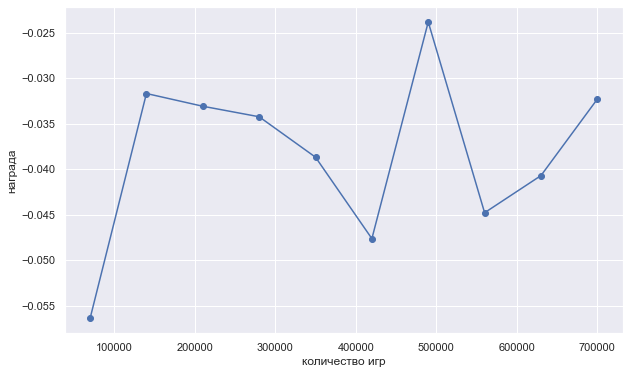

In [25]:
plt.figure(figsize=(10,6))
x, y = list(zip(*history))
ax, = plt.plot(x,y, linestyle='-', marker='o', color='b')
plt.xlabel('количество игр')
plt.ylabel('награда')
plt.show()

In [26]:
history

[(70091, -0.05638067293782919),
 (140081, -0.03168040395165768),
 (210071, -0.03307872576155887),
 (280061, -0.03423363410170962),
 (350051, -0.038673769227600366),
 (420041, -0.04761428011507084),
 (490031, -0.023824735285776288),
 (560021, -0.04476973102243083),
 (630011, -0.0406914219263315),
 (700000, -0.032294045018103526)]

### Часть третья, в главной роли — Дастин Хоффман

4. Реализуйте вариант окружения Blackjack-v0 из предыдущей части (с удвоением), в котором игрок имеет возможность “считать карты” в колоде. Это можно сделать разными способами; возможно, вам поможет статья википедии о блекджеке (а возможно, и нет).
5. Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.

In [27]:
from blackjack_count_double import BlackjackDoubleCountEnv

In [28]:
double_env_count = BlackjackDoubleCountEnv()

In [29]:
# состояния
St = list(product(range(4,32),range(1,11),(False,True), range(22*4+1)))
St2id = {}
for i, st in enumerate(St):
    St2id[st]=i

In [30]:
nA = 3 # 3 состояния
total_episodes=100000
param_list=[]
rew_list=[]
for param in tqdm(ParameterSampler(param_grid, n_iter=10, random_state=123)):
    Q = np.zeros((len(St),3))
    pi = compute_policy_by_Q(Q)
    for n in range(total_episodes):
        Q_learning_episode(double_env_count, pi, Q, nA, St2id, param['alpha'], 0.03, param['gamma'])
        pi = compute_policy_by_Q(Q)
        
    rew = get_mc_reward(pi, double_env_count, St2id)
    rew_list.append(rew)
    param_list.append(param)

100%|██████████| 10/10 [12:22<00:00, 74.27s/it]


In [31]:
rew_list

[-0.10319758396953709,
 -0.09087547375100105,
 -0.08693665215672382,
 -0.09430742814308485,
 -0.10418900286879178,
 -0.11789708836651433,
 -0.09654212257695664,
 -0.0927890420454792,
 -0.09083619968728789,
 -0.10792768170143514]

In [33]:
Q = np.zeros((len(St),3))
pi = compute_policy_by_Q(Q)
nA = 3 # 2 состояния
total_episodes=1000000
cur_pos = 1
border = np.linspace(100,total_episodes+1,11)
history = []
for n in tqdm(range(total_episodes)):
    if border[cur_pos] < n:
        rew = get_mc_reward(pi, double_env_count, St2id)
        cur_pos += 1
        history.append((n, rew))
    Q_learning_episode(double_env_count, pi, Q, nA, St2id, epsilon=0.03, **param_list[np.argmax(rew_list)])
    pi = compute_policy_by_Q(Q)
rew = get_mc_reward(pi, double_env_count, St2id)
history.append((total_episodes, rew))

100%|██████████| 1000000/1000000 [11:54<00:00, 1400.23it/s] 


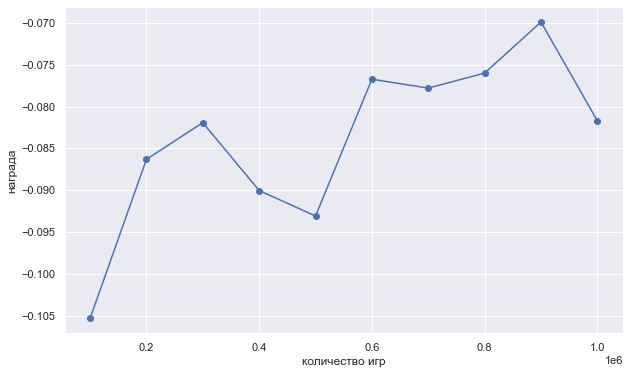

In [34]:
plt.figure(figsize=(10,6))
x, y = list(zip(*history))
ax, = plt.plot(x,y, linestyle='-', marker='o', color='b')
plt.xlabel('количество игр')
plt.ylabel('награда')
plt.show()

In [35]:
history

[(100091, -0.10531121565667383),
 (200081, -0.08630145384290962),
 (300071, -0.08192507825500965),
 (400061, -0.09002699935760465),
 (500051, -0.093071316777297),
 (600041, -0.0767338733951285),
 (700031, -0.07779035066693227),
 (800021, -0.07600215752448071),
 (900011, -0.06989267830664456),
 (1000000, -0.08169070888617959)]